In [1]:
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

result_dir_general = "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/runs/optimality_gap/CARLCartPoleEnv/eval_general"
result_dirs_oracle = [
    "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/runs/optimality_gap/CARLCartPoleEnv/eval_oracle"
]
context_feature = "pole_length"


figdir = Path(result_dir_general).parent / "figures"
figdir.mkdir(exist_ok=True, parents=True)


from experiments.evaluation.loading import *

/home/benjamin/.conda/envs/carl/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
reload = False
# from general agent: gather final performance on each context
df_general = load(folder_eval=result_dir_general, rpc_fn="tmp/rpc_general.csv", reload_rpc=reload)
df_general["origin"] = "general"

# from oracles: gather evaluation performance on each context
df_oracle = pd.concat([
    load(
        folder_eval=p, 
        rpc_fn=f"tmp/rpc_oracle_{i}.csv",
        reload_rpc=reload,
        is_optgap_exp=True
    ) for i, p in enumerate(result_dirs_oracle)
    ]).reset_index(drop=True)
df_oracle["origin"] = "oracle"

n_reps = 10
df = pd.concat([df_general, df_oracle]).reset_index(drop=True)
df = df[df["rep"] < n_reps]
df["origin"][df["origin"] == "oracle"] = "specialized"

/tmp/ipykernel_26979/3562807805.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["origin"][df["origin"] == "oracle"] = "specialized"


In [4]:
df_general.columns, df_oracle.columns

(Index(['context_id', 'return', 'force_magnifier', 'gravity',
        'initial_state_lower', 'initial_state_upper', 'masscart', 'masspole',
        'pole_length', 'update_interval', 'seed', 'visibility', 'n_contexts',
        'path', 'rep', 'origin'],
       dtype='object'),
 Index(['context_id', 'return', 'force_magnifier', 'gravity',
        'initial_state_lower', 'initial_state_upper', 'masscart', 'masspole',
        'pole_length', 'update_interval', 'seed', 'visibility', 'n_contexts',
        'path', 'rep', 'origin'],
       dtype='object'))

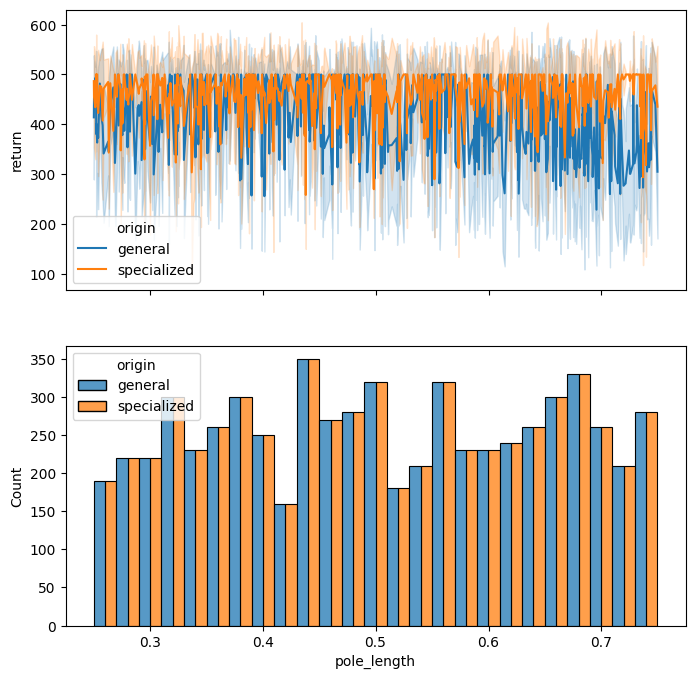

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 8))
axes = fig.subplots(nrows=2, sharex=True)
ax = axes[0]
ax = sns.lineplot(data=df, x=context_feature, y="return", hue="origin", errorbar="sd", ax=ax)

ax = axes[1]
ax = sns.histplot(data=df, x=context_feature, bins=25, hue="origin", ax=ax, multiple="dodge")
plt.show()

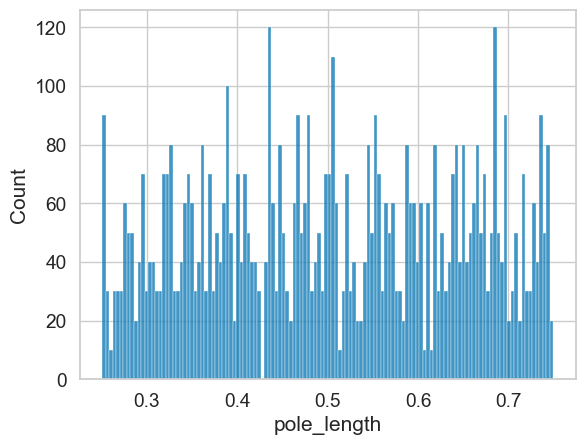

In [6]:
# Context Values
fig_fn = figdir / "context_values.pdf"
sns.set(font_scale=1.25)
sns.set_palette("colorblind")
sns.set_style("whitegrid")

ax = sns.histplot(data=df[df["origin"]=="general"], x=context_feature, bins=128, stat="count")

fig = ax.get_figure()
fig.savefig(fig_fn, bbox_inches="tight", dpi=300)

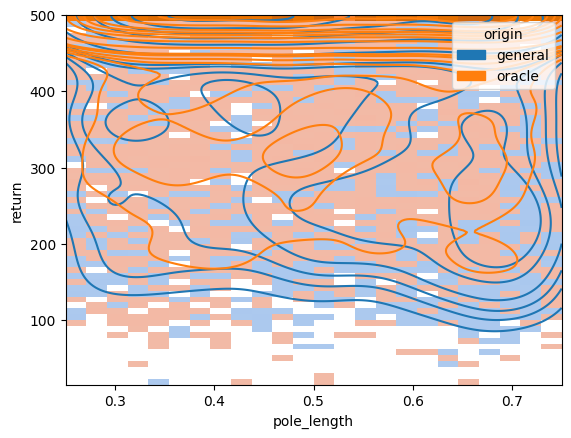

In [5]:
filtered_df = df.copy()
# filtered_df = filtered_df[(filtered_df["seed"] != 7) & (filtered_df["seed"] != 8) & (filtered_df["seed"] != 2) & (filtered_df["seed"] != 4)]
ax = sns.kdeplot(data=filtered_df, x=context_feature, y="return", hue="origin", levels=15, cut=0)
ax = sns.histplot(data=filtered_df, x=context_feature, y="return", hue="origin")

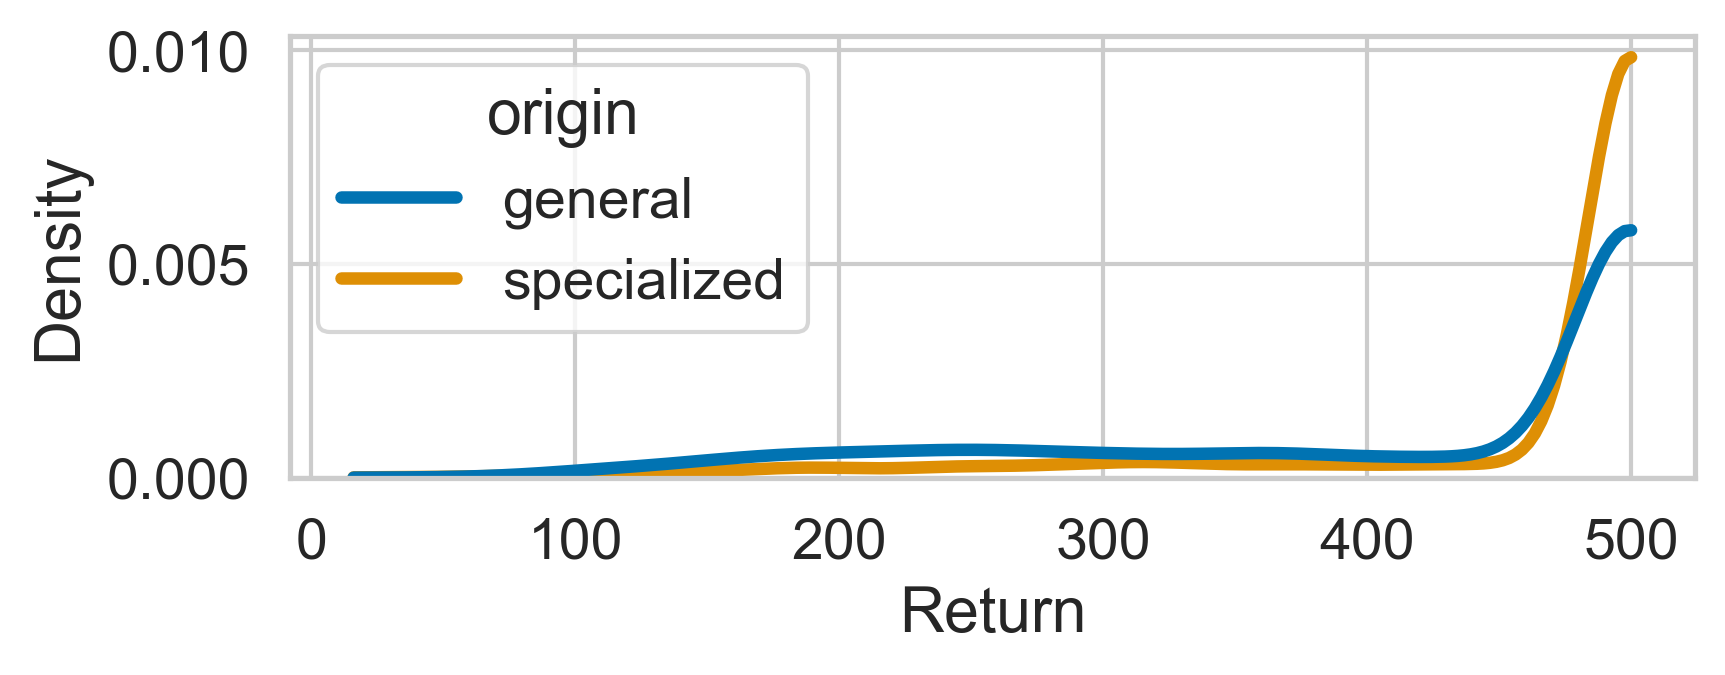

In [4]:
fig_fn = figdir / "test_return_density.pdf"
sns.set(font_scale=1.25)
sns.set_palette("colorblind")
sns.set_style("whitegrid")
fig = plt.figure(figsize=(6,2.5), dpi=300)
ax = fig.add_subplot(111)
ax = sns.kdeplot(data=df, x="return", hue="origin", levels=20, cut=0, lw=3, ax=ax)
ax.set_xlabel("Return")
fig.set_tight_layout(True)
fig.savefig(fig_fn, bbox_inches="tight", dpi=300)
plt.show()

(100, 64) 10 [ 1  2  3  4  5  6  7  8  9 10]
(100, 64) 10 [ 1  2  3  4  5  7  8  9 10  6]
(5, 3.0)


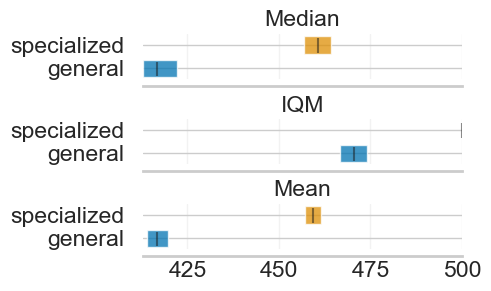

In [36]:
from rliable import library as rly
from rliable import metrics
import importlib
import rliable.plot_utils
importlib.reload(rliable.plot_utils)

fig_fn = figdir / "test_return_statistics.pdf"
sns.set(font_scale=0.8)
sns.set_palette("colorblind")
sns.set_style("whitegrid")

filtered_df = df.copy()
# filtered_df = filtered_df[(filtered_df["seed"] != 7) & (filtered_df["seed"] != 8) & (filtered_df["seed"] != 2) & (filtered_df["seed"] != 4)]
reps = 10000
xlabel = ""

metric_names = ['Median', 'IQM', 'Mean']  # , 'Optimality Gap']
aggregate_func = lambda x: np.array([
  metrics.aggregate_median(x),
  metrics.aggregate_iqm(x),
  metrics.aggregate_mean(x),
  # metrics.aggregate_optimality_gap(x)
  ])


# Create score matrix
# Scores: (num_points x num_tasks), here:
#         (num_seeds * num_reps x num_tasks)
# Pendulum: num_tasks = n_contexts = 100
score_dict = {}
for group_id, group_df in filtered_df.groupby("origin"):
  n_seeds = group_df["seed"].nunique()
  n_context_ids = group_df["context_id"].nunique()
  scores = np.zeros((n_seeds * n_reps, n_context_ids))
  print(scores.shape, n_seeds, group_df["seed"].unique())
  for i, ((seed, rep), gdf) in enumerate(group_df.groupby(["seed", "rep"])):
    R = gdf["return"]
    if len(R) == 63:
      for p in gdf["path"]:
        printr(p)
    n = len(gdf)
    index = (seed - 1) * n_seeds + rep  # seed is 1-based
    scores[i] = R
  score_dict[group_id] = scores


aggregate_scores, aggregate_score_cis = rly.get_interval_estimates(
        score_dict, aggregate_func, reps=reps)

fig, axes = rliable.plot_utils.plot_interval_estimates(
    aggregate_scores, aggregate_score_cis,
    metric_names=metric_names,
    algorithms=list(score_dict.keys()), xlabel=xlabel,
    asrows=True,
    row_height=0.5,
    interval_height=0.75
)
fig.set_tight_layout(True)
fig.savefig(fig_fn, bbox_inches="tight", dpi=300)
plt.show()



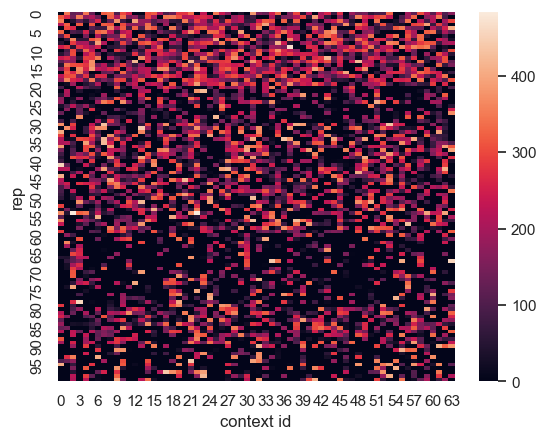

In [20]:
fig_fn = figdir / "test_return_gap.pdf"
sns.set(font_scale=1.)
sns.set_palette("colorblind")
sns.set_style("whitegrid")


gap = np.abs(score_dict["oracle"] - score_dict["general"])
df_gap = pd.DataFrame(gap)

ax = sns.heatmap(data=gap)
ax.set_xlabel("context id")
ax.set_ylabel("rep")
plt.show()

fig = ax.get_figure()
fig.savefig(fig_fn, bbox_inches="tight", dpi=300)